In [77]:
import itertools
import cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV

In [2]:
plt.style.use('ggplot')
%matplotlib inline

## Index
* [Load emails from CSV](#Load-emails-information-from-CSV-file)
* [Answer Question 1](#Answer-question-1)
* [Explore the data](#Explore-the-data)
    * [Chi-square test and F-test](#Chi-square-test-and-F-test)
    * [previous purchase history vs. response](#previous-purchase-vs.-response)
    * [user's country vs. response](#user's-country-vs.-response)
    * [email's version vs. response](#email's-version-vs.-response)
    * [weekday vs. reponse](#weekday-vs.-response)
    * [email text vs. response](#email-text-vs.-response)
    * [sending hour vs. response](#sending-hour-vs.-response)
* [Answer Question 4](#Answer-question-4)
* [Build Predictive Model](#Build-Predictive-Model)
    * [Prepare the data](#Prepare-the-data)
    * [Train the model](#Train-the-model)
    * [Plot ROC curve and choose better probability threshold](#Plot-ROC-curve-and-choose-better-probability-threshold)
    * [Plot-Precision-Recall-Curve](#Plot-Precision-Recall-Curve)
* [Answer question 2 and question 3's first part](#Answer-question-2-and-question-3's-first-part)
* [Answer question 3's second part](#Answer-question-3's-second-part)

## Load emails information from CSV file

In [3]:
emails = pd.read_csv("email_table.csv",index_col="email_id")
emails["paragraphs"] = np.where(emails.email_text == 'short_email',2,4)
del emails["email_text"]

emails["is_personal"] = (emails.email_version == "personalized").astype(np.int)
del emails["email_version"]

weekday2index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
emails["weekday"] = emails.weekday.map(weekday2index)

emails.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)

assemble emails' response together

In [4]:
emails["response"] = "received"

open_users = pd.read_csv("email_opened_table.csv").email_id
emails.loc[open_users,"response"] = "opened"

click_users = pd.read_csv("link_clicked_table.csv").email_id
emails.loc[click_users,"response"] = 'clicked'

In [5]:
emails.head()

,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,
85120,2,7,US,5,2,1,received
966622,12,7,UK,2,4,1,clicked
777221,11,3,US,2,4,1,received
493711,6,1,UK,1,2,0,received
106887,14,1,US,6,4,0,received


In [6]:
emails.to_csv("clean_emails.csv",index_label="email_id")

## Answer question 1
* What percentage of users opened the email?
* what percentage clicked on the link within the email?

In [7]:
rslt_dist = emails.response.value_counts(normalize=True)
rslt_dist

received    0.89605
opened      0.08276
clicked     0.02119
Name: response, dtype: float64

In [8]:
print "{:.2f}% of users opened the email".format((1 - rslt_dist.received) * 100)
print "{:.2f}% of users clicked the link".format(rslt_dist.clicked * 100)

10.39% of users opened the email
2.12% of users clicked the link


## Explore the data

In [21]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_plotbar(key):
    grpresult = emails.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['clicked']].plot(kind='bar',title='click ratio vs. {}'.format(key))
    plt.ylabel('click ratio')
    return grpresult

### Chi-square test and F-test

In [30]:
resp_lb_encoder = LabelEncoder()
cnty_lb_encoder = LabelEncoder()

X = emails.copy()
y = resp_lb_encoder.fit_transform(X.response)
del X["response"]

feat_names = ["hour","weekday","country","purchases","paragraphs","is_personal" ]
X = X.loc[:,feat_names]
X["country"] = cnty_lb_encoder.fit_transform(X.country)

chi2scores,_ = chi2(X,y)
fscores,_ = f_classif(X,y)

feat_scores = pd.DataFrame({"chi2scores":chi2scores,"fscores":fscores},index=feat_names)

In [31]:
feat_scores.sort_values(by='chi2scores',ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
paragraphs,53.952439,81.209295


In [32]:
feat_scores.sort_values(by="fscores",ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
paragraphs,53.952439,81.209295
hour,147.815921,33.992047


from the test result, we can know that,
* important features: ** previous purchase counts, user's country, email's version (personal or general) **
* not so important features **maybe** include: ** weekday, email's text (short or long), hour to send the email **

### previous purchase vs. response

In [22]:
rslt_grpby_purchase = emails.groupby("purchases").apply(count_result_ratio).unstack()
rslt_grpby_purchase.fillna(value=0,inplace=True)

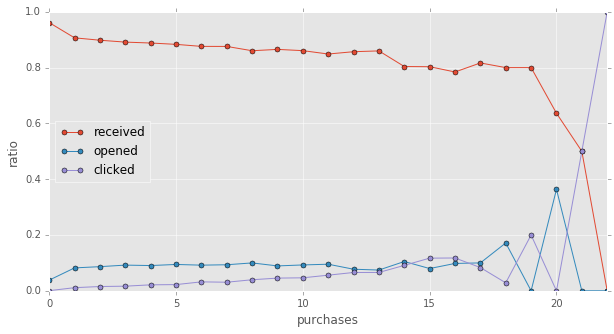

In [23]:
plt.rc('figure', figsize=(10, 5))
rslt_grpby_purchase.loc[:,["received","opened",'clicked']].plot(marker='o',markersize=5)
plt.ylabel("ratio")

from above plot, we can know, <span style='color:orange;font-weight:bold;font-size:1.5em'>the more items a certain user purchased previously, the more likely that user will open the email or click the link.</span>

### user's country vs. response

response,received,opened,clicked,total
country,,,,
ES,0.960570,0.031103,0.008327,9967.0
FR,0.958779,0.033217,0.008004,9995.0
UK,0.879282,0.096043,0.024675,19939.0
US,0.880481,0.095160,0.024360,60099.0


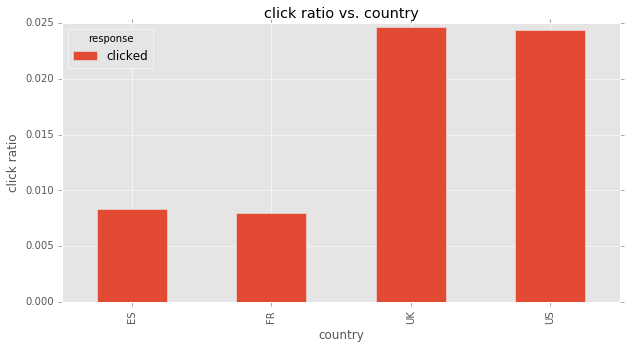

In [24]:
grp_count_plotbar('country')

from above plots, we see that, 'open percentage' and 'click percentage' is much higher (nearly 3 times) in UK and US than in France and Spain. 

this may be the <span style='color:orange;font-weight:bold;font-size:1.5em'>translation issue. I guess the emails are written in English, which is unreadable to some non-English-speaking users, which cause the low 'click ratio' in non-English-speaking countries.</span>

### email's version vs. response

response,received,opened,clicked,total
is_personal,,,,
0,0.920034,0.064829,0.015137,50209.0
1,0.871864,0.100842,0.027294,49791.0


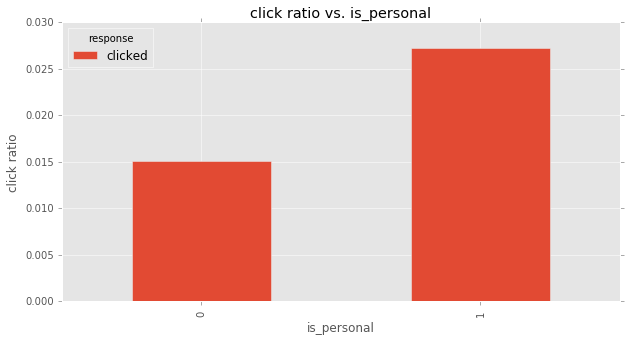

In [25]:
grp_count_plotbar('is_personal')

<span style='color:orange;font-weight:bold;font-size:1.5em'>'personalized email' has higher 'click ratio' than 'general email'</span>. this is very easy to understand. Having my name in the recipient, at least I am some kind of 'important' to the company, other than some ordinary people which the company don't bother to remember his name.

### weekday vs. response

response,received,opened,clicked,total
weekday,,,,
1,0.883590,0.093504,0.022906,14363.0
2,0.879092,0.096019,0.024889,14143.0
3,0.879296,0.093084,0.027620,14084.0
4,0.881348,0.094207,0.024445,14277.0
5,0.925019,0.060944,0.014037,14177.0
6,0.912005,0.070149,0.017846,14569.0
7,0.911448,0.071801,0.016751,14387.0


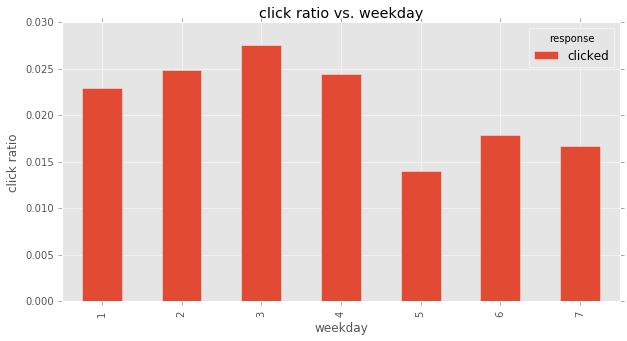

In [26]:
grp_count_plotbar('weekday')

<span style='color:orange;font-weight:bold;font-size:1.5em'>Friday, Saturday, Sunday have obviously lower 'click ratio' than Monday to Thursday</span>. People normally don't process emails during weekends.

### email text vs. response

response,received,opened,clicked,total
paragraphs,,,,
2,0.883698,0.092430,0.023872,49724.0
4,0.908266,0.073196,0.018538,50276.0


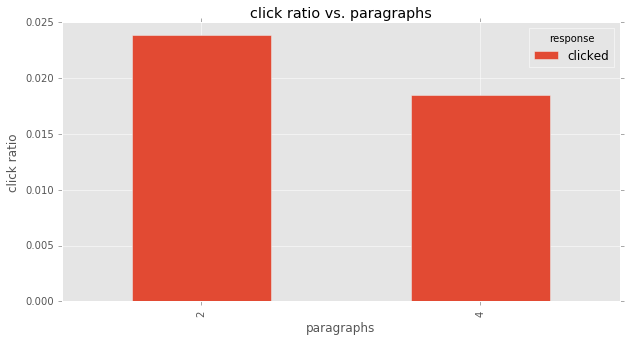

In [27]:
grp_count_plotbar('paragraphs')

### sending hour vs. response

response,received,opened,clicked,total
hour,,,,
1,0.910840,0.071032,0.018128,2703.0
2,0.911589,0.072089,0.016322,3676.0
3,0.915184,0.065293,0.019523,4610.0
4,0.911419,0.072394,0.016186,5622.0
5,0.917417,0.064570,0.018013,6551.0
6,0.909176,0.073677,0.017147,7465.0
7,0.909434,0.072282,0.018284,8204.0
8,0.911407,0.069659,0.018933,8398.0
9,0.873725,0.100481,0.025794,8529.0


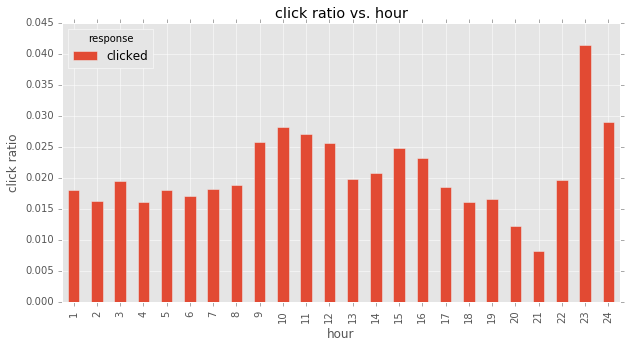

In [33]:
grp_count_plotbar('hour')

although from above plot, it seems 'sending hour' has some impact on 'clicked ratio'. however, that may be caused by much fewer examples in late hours. also according to [statistical test](#Chi-square-test-and-F-test)'s result, I don't think 'sending hour' is an important feature, and won't include it in my model.

## Answer question 4
Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.

from above explorary analysis, I can find some interesting patterns listed below:
* [The more item a certain user purchased in the past, the more likely that user will click the link](#previous-purchase-vs.-response)
* [Users from English-speaking coutries are more likely to click the link](#user's-country-vs.-response), which may be caused by some translation issue.
* [Personalized email is more likely to be opened and clicked](#email's-version-vs.-response)
* [Emails sent at weekends is less likely to be opened and clicked](#weekday-vs.-response)
* [Sending hour and #Paragraphs are not very important features to affect click rate](#Chi-square-test-and-F-test)

## Build Predictive Model

In this section, I will build a model to predict whether a user will open the email and click the link inside it.

### Prepare the data

In [35]:
del X
X = emails.copy()

# select original features
# 'paragraphs' isn't an important feature, but I will include it, and see how RF say about it
X = X.loc[:,["country","purchases","paragraphs","is_personal"] ]

# create new feature
X['is_weekend'] = (emails.weekday>=5).astype(int)

# One-Hot-Encode 'country' feature
X = pd.get_dummies(X,columns=["country"],drop_first=True)

# prepare the target
y = (emails.response == 'clicked').astype(int)

# split for training and testing
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33333)

### Train the model

Due to time limitation, I will just train one RandomForest model, and use Randomized Grid Search to tune the hyper-parameters in a small range. 

<span style='color:red;font-weight:bold;font-size:1.5em'>If given sufficient time, I will apply fowllowing strategies to improve the model:</span>
* <span style='color:red'>build multiple models, and ensemble them (average or stacking) to improve the prediction performance.</span>
* <span style='color:red'>grid search in a broader range to find better hyper-parameters.</span>
* <span style='color:red'>perform careful error analysis, to have more clear direction about how to tune the hyper-parameters.</span>

In [36]:
rf = RandomForestClassifier(oob_score=True,verbose=1,n_jobs=-1)

param_dist = {"n_estimators": [30,50,100],
              "max_depth": [6, 10, None],
              "min_samples_split": [2,6,10],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf": [1,3,10]}
searchcv = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                              scoring = "roc_auc",n_iter=100,n_jobs=-1,verbose=1)

searchcv.fit(Xtrain,ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=1, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [30, 50, 100], 'min_samples_split': [2, 6, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [6, 10, None], 'min_samples_leaf': [1, 3, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='roc_auc', verbose=1)

In [37]:
searchcv.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [38]:
searchcv.best_score_ 

0.73767137598996579

In [39]:
bestrf = searchcv.best_estimator_

In [43]:
# feature importance
pd.Series(bestrf.feature_importances_,index=X.columns).sort_values(ascending=False)

purchases      0.672834
is_personal    0.107435
is_weekend     0.065849
country_FR     0.049651
country_US     0.045154
country_UK     0.034007
paragraphs     0.025070
dtype: float64

above feature importance match the result from [explorary analysis](#Explore-the-data).

In [40]:
ytrain_pred = bestrf.predict(Xtrain)
print classification_report(ytrain,ytrain_pred)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


             precision    recall  f1-score   support

          0       0.98      1.00      0.99     65260
          1       0.00      0.00      0.00      1407

avg / total       0.96      0.98      0.97     66667



/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
ytest_pred = bestrf.predict(Xtest)
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     32621
          1       0.00      0.00      0.00       712

avg / total       0.96      0.98      0.97     33333



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


<span style='color:orange;font-size:1.5em'>since the data is highly imbalanced (positive examples is only 2% of the total examples), if using default probability threshold (0.5), the model just classify every example as negative, so we need to plot the ROC curve and choose a better probability threshold.</span>

### Plot ROC curve and choose better probability threshold

In [44]:
ytest_pred_proba = bestrf.predict_proba(Xtest)[:,1]
fpr,tpr,thresholds = roc_curve(ytest,ytest_pred_proba)
roc_results = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


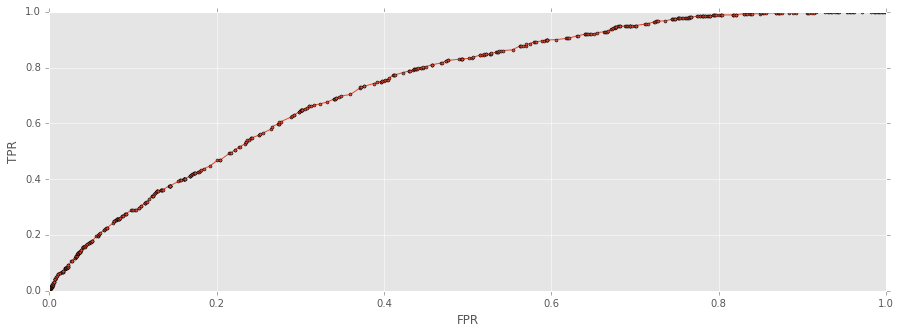

In [54]:
plt.plot(fpr,tpr,marker='o',markersize=3)
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.rc('figure',figsize=(1,5))

according to above ROC curve and make a compromise between Precision and Recall, <span style='color:orange;font-weight:bold;font-size:1.5em'>I decide to choose a threshold which makes TPR at about 0.6, then FPR will be about 0.3, which I think is acceptable.</span>

In [55]:
roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:]

,FPR,TPR,Thresholds
258,0.275007,0.603933,0.027749
259,0.277153,0.606742,0.027388
260,0.288556,0.622191,0.027378
261,0.289967,0.625000,0.027083
262,0.292358,0.629213,0.027081
263,0.292511,0.629213,0.026810
264,0.297937,0.640449,0.026754
265,0.298243,0.640449,0.026709
266,0.300205,0.646067,0.026657
267,0.300604,0.647472,0.026623


In [56]:
# choose a threshold based on ROC
pos_prob_threshold = 0.026709

In [57]:
def adjust_predict(X,threshold):
    proba = bestrf.predict_proba(X)[:,1]
    return (proba >=threshold).astype(int)

In [59]:
ytrain_adjpred = adjust_predict(Xtrain,pos_prob_threshold)
print classification_report(ytrain,ytrain_adjpred)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


             precision    recall  f1-score   support

          0       0.99      0.70      0.82     65260
          1       0.04      0.65      0.08      1407

avg / total       0.97      0.70      0.81     66667



In [60]:
ytest_adjpred = adjust_predict(Xtest,pos_prob_threshold)
print classification_report(ytest,ytest_adjpred)

             precision    recall  f1-score   support

          0       0.99      0.70      0.82     32621
          1       0.04      0.64      0.08       712

avg / total       0.97      0.70      0.81     33333



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


<a id='test-precision-recall'></a>
<span style='color:orange;font-weight:bold;font-size:1.5em'>more accurate Precision and Recall</span>

In [81]:
print "test precision: {:.2f}%".format(precision_score(ytest,ytest_adjpred) * 100)
print "test recall: {:.2f}%".format(recall_score(ytest,ytest_adjpred) * 100)

test precision: 4.48%
test recall: 64.04%


In [61]:
with open("final_model.pkl","wb") as outf:
    cPickle.dump(bestrf,outf)
    cPickle.dump(pos_prob_threshold,outf)

### Plot Precision-Recall Curve

In [64]:
precisions,recalls,thresholds = precision_recall_curve(ytest,ytest_pred_proba)

(0, 0.1)

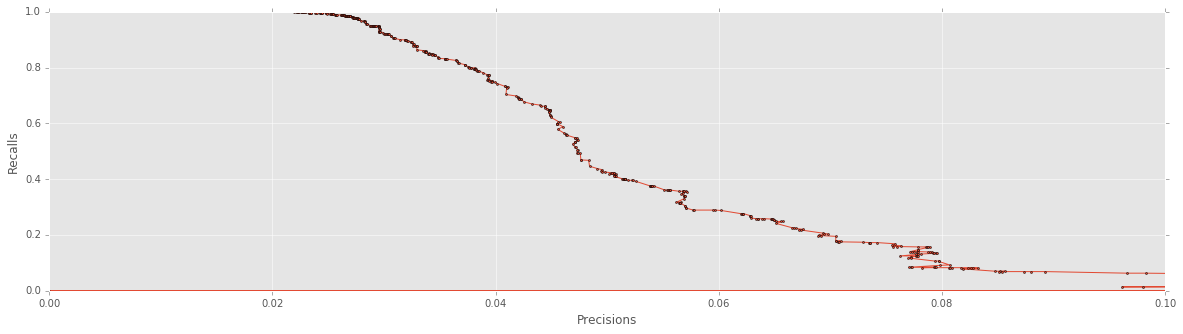

In [82]:
plt.plot(precisions,recalls,marker='o',markersize=2)
plt.xlabel("Precisions")
plt.ylabel('Recalls')
plt.rc('figure',figsize=(20,5))
plt.xlim(0,0.1)

## Answer question 2 and question 3's first part

I have build a RandomForest model in previous section which predicts whether a user will click the link or not. Then the new email campaign strategy will be: <span style='color:orange;font-weight:bold;font-size:1.5em'>only send email to users which my RF model predicts positive.</span>


according to its [predictive result on test set](#test-precision-recall)
* <span style='color:orange;'>my model will cover 64% of valued users which will click the link. </span>
* <span style='color:orange;'>4.48% of the receiver will open email and click the link. </span> compare with [old strategy](#Answer-question-1), whose click rate is ** 2.12% **, <span style='color:red;'>my new strategy can double the click rate</span>.

## Answer question 3's second part

To test my conclusion, we need to perform a A/B test:
1. randomly assign users to two groups, Control group and Experiment group.
2. in Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
3. in Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
4. then we preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.